In [170]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp
from time import time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from scipy.stats import norm
from scipy.stats.mstats import gmean

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# define data dictionaries
X = {}
y = {}
targ = {}
ref = {}

for t in ['train', 'dev', 'test']:
    dat = pd.read_csv('../data/modelInputs/standardizedGrowth/' + t + '.csv', index_col=0)
    ref[t] = dat[['Drug', 'Concentration']]
    y[t] = dat['Growth']
    X[t] = dat[['Cellline'] + list(dat.columns[4:])]
    
for t in ['train', 'dev', 'test']:
    targ[t] = norm.ppf((y[t]+1.)/2.)
    targ[t][targ[t] > 8] = 8
    targ[t][targ[t] < -8] = -8

In [30]:
dummified_celllines = pd.get_dummies(X['train']['Cellline'].append(X['dev']['Cellline']).append(X['test']['Cellline']))

for t in ['train', 'dev', 'test']:
    X[t] = X[t].drop('Cellline', axis=1).merge(dummified_celllines, how='left', left_index=True, right_index=True)

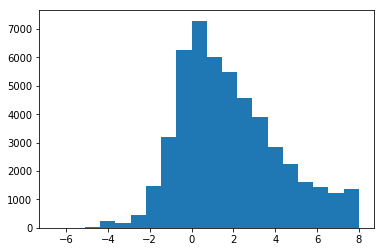

In [19]:
plt.hist(targ['train'], bins=20)
plt.show()

In [74]:
print(1/(np.sum(clf_transformer(y['train']))/ len(y['train'])))
print(1/(np.sum(clf_transformer(y['train'])==0)/ len(y['train'])))

32.293851132686086
1.0319551593621379


In [ ]:
def weighter(y, alpha=0):
    '''
    When alpha is set to 0, this returns the inverse class distributions for weights
    
    Else alpha of geomean ratio is penalized
    '''
    unique = np.unique(y).tolist()
    ratios = len(y) / (2. * np.bincount(np.array(y, dtype=np.int64)))
    
    ratios = alpha * gmean(ratios) + (1 - alpha) * ratios
    
    return dict(zip(unique, ratios))

In [174]:
# set parameters
n_jobs = 15
clf = None
clf_class_weights = [None, 'balanced', weighter(clf_transformer(y['train']), .25), weighter(clf_transformer(y['train']), .5), weighter(clf_transformer(y['train']), .75)]
threshes=[1e-12, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2]
clf_loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
l1_ratios=[0, 0.1, 0.5, 0.9, 0.99]
clf_alphas = [.0001]

def thresholder(thresh, arr):
    return (arr > 1- thresh) * 1.

def weight_hash_helper(weights):
    if type(weights) == dict:
        return tuple(list(weights.values()))
    else:
        return weights


In [175]:
clf_holder = {}
val_scores = {}
for loss in clf_loss:
    for weights in clf_class_weights:
        for ratio in l1_ratios:
            for alpha in clf_alphas:
                clf_holder[(loss, weight_hash_helper(weights), ratio, alpha)] = BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet',                   
                                                                                                    loss=loss, 
                                                                                                    learning_rate='optimal',
                                                                                                    class_weight=weights, 
                                                                                                    l1_ratio=ratio,
                                                                                                    alpha=alpha,
                                                                                                    random_state=1920),
                                        n_estimators=30,
                                        max_samples=0.632,
                                        n_jobs=n_jobs)

In [ ]:
# sample fitter
with tqdm(total = len(threshes) * len(clf_holder)) as pbar:
    for hyper, clf in clf_holder.items():
        for thresh in threshes:
            # make a transformer dynamically
            clf_transformer = ft.partial(thresholder, thresh)

            clf.fit(X['train'].sample(frac=0.02, random_state=1920), clf_transformer(pd.Series(y['train']).sample(frac=0.02, random_state=1920)))

            try:
                val_scores[hyper + (thresh,)] = roc_auc_score(clf_transformer(pd.Series(y['dev']).sample(frac=0.02, random_state=1920)), clf.predict(X['dev'].sample(frac=0.02, random_state=1920)))
            except:
                pass
            
            pbar.update(1) 

In [176]:
with tqdm(total = len(threshes) * len(clf_holder)) as pbar:
    for hyper, clf in clf_holder.items():
        for thresh in threshes:
            # make a transformer dynamically
            clf_transformer = ft.partial(thresholder, thresh)

            clf.fit(X['train'], clf_transformer(y['train']))

            val_scores[hyper + (thresh,)] = roc_auc_score(clf_transformer(y['dev']), clf.predict(X['dev']))
            
            pbar.update(1)

100%|██████████| 5145/5145 [8:31:24<00:00,  6.81s/it]


In [178]:
pd.Series(val_scores).to_csv('../results/validation_scores_auc.csv')

In [207]:
clf_transformer = ft.partial(thresholder, 1e-12)
clf =  BaggingClassifier(base_estimator=SGDClassifier(penalty='elasticnet', loss='hinge', learning_rate='optimal', class_weight='balanced', l1_ratio=0.99, alpha=3e-5, random_state=1920), n_estimators=20, max_samples=0.632, n_jobs=n_jobs)
clf.fit(X['train'], clf_transformer(y['train']))
preds = clf.predict(X['dev'])
print(roc_auc_score(clf_transformer(y['dev']), preds))
print(accuracy_score(clf_transformer(y['dev']), preds))

0.8337210231348859
0.8568221901555235


In [205]:
clf.base_estimator_


SGDClassifier(alpha=3e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.99, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=1920, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

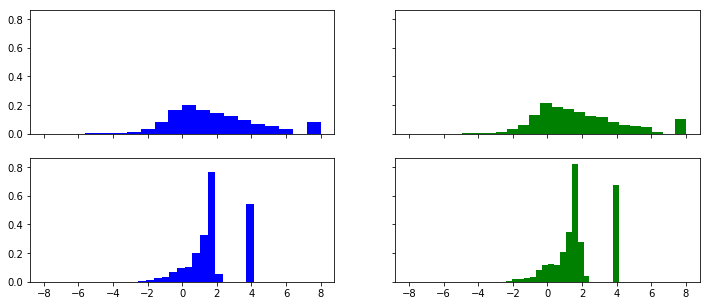

In [391]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

axes[0][0].hist(targ['train'], bins=20, density=True, color='b')
axes[0][1].hist(targ['dev'], bins=20, density=True, color='g')

p_train = mod.predict(X['train'])
p_dev = mod.predict(X['dev'])

axes[1][0].hist(p_train, bins=20, density=True, color='b')
axes[1][1].hist(p_dev, bins=20, density=True, color='g')

plt.show()

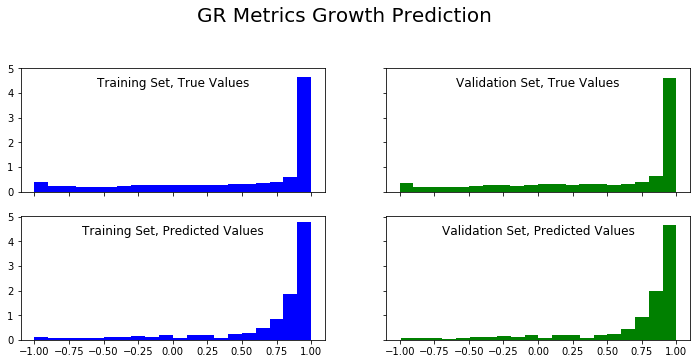

In [404]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

axes[0][0].hist(y['train'], bins=20, density=True, color='b')
axes[0][0].set_title('Training Set, True Values', y=.8)

axes[0][1].hist(y['dev'], bins=20, density=True, color='g')
axes[0][1].set_title('Validation Set, True Values', y=.8)

axes[1][0].hist((norm.cdf(p_train)-.5)*2, bins=20, density=True, color='b')
axes[1][0].set_title('Training Set, Predicted Values', y=.8)

axes[1][1].hist((norm.cdf(p_dev)-.5)*2, bins=20, density=True, color='g')
axes[1][1].set_title('Validation Set, Predicted Values', y=.8)

plt.show()

In [431]:
print(np.corrcoef(y['train'], p_train))
print(np.corrcoef(y['dev'], p_dev))

[[1.         0.62368565]
 [0.62368565 1.        ]]
[[1.         0.61981648]
 [0.61981648 1.        ]]


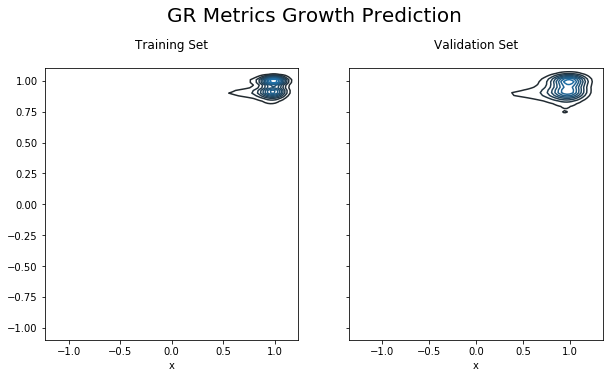

In [429]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

sns.kdeplot(y['train'], (norm.cdf(p_train)-.5)*2,ax=axes[0], shade=True)
axes[0].set_title('Training Set', y=1.05)

sns.kdeplot(y['dev'], (norm.cdf(p_dev)-.5)*2, ax = axes[1], shade=True)
axes[1].set_title('Validation Set', y=1.05)

plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, sharey=True)

p_train = mod.predict(X['train'])
p_dev = mod.predict(X['dev'])

axes[0].hist(p_train, bins=20, density=True, color='b')
axes[1].hist(p_dev, bins=20, density=True, color='g')

plt.show()

In [405]:
mod.clf.score(X['dev'], (y['dev']>1-1e-12)*1.)

0.8066378066378066

In [388]:
display(np.mean(targ['train'][y['train']>1-1e-12]))
display(np.mean(targ['dev'][y['dev']>1-1e-12]))

8.0

8.0

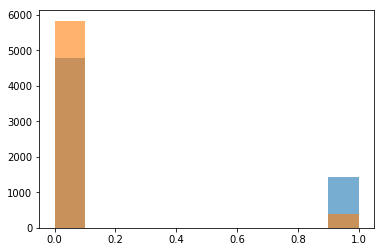

In [406]:
plt.hist(mod.clf.predict(X['dev']), alpha=0.6)
plt.hist((y['dev']>1-1e-12)*1., alpha=0.6)

plt.show()